# NewYork Taxi demand prediction with SARIMAX using weather data:

In this article, we will present a method for predicting the number of taxi pickups in a certain area of NewYork. We will perform spatiotemporal time series analysis then we will apply the well known statistical method SARIMA on the agregated data that includes the weather data.

## **Data informations :** 

### **Taxi Data**
* We will be using NewYork Taxi demand public data availble on: 
https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

* Here we will use data from Jan 2015 to Fev 2016

### **Weither Data**

* For weather data we will use data from the VisualCrossing  provider: https://visualcrossing.com/weather-data




Use [this Tutorial](https://medium.com/@abdelkader_bouregag/download-large-data-sets-to-google-colab-in-few-seconds-for-your-data-science-project-6cfac68ad35) to upload Data quicky from NYC dataset website to your google drive account:  

**Read my story on medium for an explination of this code: [Here](https://medium.com/@abdelkader_bouregag/newyork-taxi-demand-forecasting-with-sarimax-using-weather-data-d46c041f3f9c)**

In [ ]:
pip install "dask[dataframe]"

In [ ]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from datetime import datetime
from sklearn.cluster import MiniBatchKMeans, KMeans
import warnings
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import time
import folium
from folium import Choropleth ,  Circle, Marker

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Creating files for storing cleaned data by cluster // Execute only once 
import pandas
result = pandas.DataFrame(columns = ['time','hour','day','dayofweek','temperature','wind_speed','demand'])
#uncoment the line of code and execute
for i in range(30):
  #result.to_csv("/content/drive/My Drive/data-sets/nyc/NYC-data-2015/cluster_"+str(i).zfill(2)+".csv", sep=',',index=False)



#Reading/cleaning Janury 2015 Data

In [ ]:
data_Jan_2015 = dd.read_csv("/content/drive/My Drive/data-sets/nyc/nyc-data/yellow_tripdata_2015-01.csv")
data_Jan_2015.head()

VendorID tpep_pickup_datetime  ... improvement_surcharge  total_amount
0         2  2015-01-15 19:05:39  ...                   0.3         17.05
1         1  2015-01-10 20:33:38  ...                   0.3         17.80
2         1  2015-01-10 20:33:38  ...                   0.3         10.80
3         1  2015-01-10 20:33:39  ...                   0.3          4.80
4         1  2015-01-10 20:33:39  ...                   0.3         16.30

[5 rows x 19 columns]

In [ ]:
meteo_Jan_2015 = pd.read_csv("/content/drive/My Drive/data-sets/nyc/nyc-weather/NYC-01-2015.csv")
meteo_Jan_2015.head()

Location   Address  ...  Relative Humidity Conditions
0  newyork  New york  ...              45.19      Clear
1  newyork  New york  ...              43.66      Clear
2  newyork  New york  ...              47.47      Clear
3  newyork  New york  ...              46.89      Clear
4  newyork  New york  ...              43.14      Clear

[5 rows x 16 columns]

In [ ]:
#Adding Trip Duration Column
def timeToUnix(t):
    change = datetime.strptime(t, "%Y-%m-%d %H:%M:%S")
    t_tuple = change.timetuple() 
    return time.mktime(t_tuple) + 3600

def prepare_dataframe(df):
    duration = df[["tpep_pickup_datetime", "tpep_dropoff_datetime"]].compute()
    pickup_time = [timeToUnix(pkup) for pkup in duration["tpep_pickup_datetime"].values]
    dropoff_time = [timeToUnix(drpof) for drpof in duration["tpep_dropoff_datetime"].values]
    trip_duration = (np.array(dropoff_time) - np.array(pickup_time))/float(60)  #trip duration in minutes
    
    NewFrame = df[['tpep_pickup_datetime','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    NewFrame["trip_duration"] = trip_duration
    NewFrame["pickup_time"] = pickup_time
    NewFrame["speed"] = (NewFrame["trip_distance"]/NewFrame["trip_duration"])*60  #speed in miles/hr
    
    return NewFrame

In [ ]:
new_data_Jan_2015 = prepare_dataframe(data_Jan_2015)

In [ ]:
locations = new_data_Jan_2015[['pickup_latitude', 'pickup_longitude']][:2000]
locationlist = locations.values.tolist()
map = folium.Map(location=[40.73,-73.93], zoom_start=12)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(map)
map

## Trip Duration

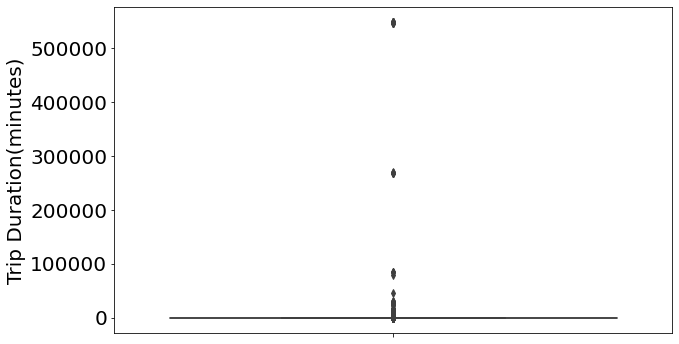

In [ ]:
plt.figure(figsize = (10,6))
sns.boxplot("trip_duration", data = new_data_Jan_2015, orient = "v")
plt.tick_params(labelsize = 20)
plt.ylabel("Trip Duration(minutes)", fontsize = 20)
plt.show()

In [ ]:
#Deleting courses with trip duration > 12h
new_data_Jan_2015 = new_data_Jan_2015[(new_data_Jan_2015.trip_duration>1) & (new_data_Jan_2015.trip_duration<720)]

## Trip distance

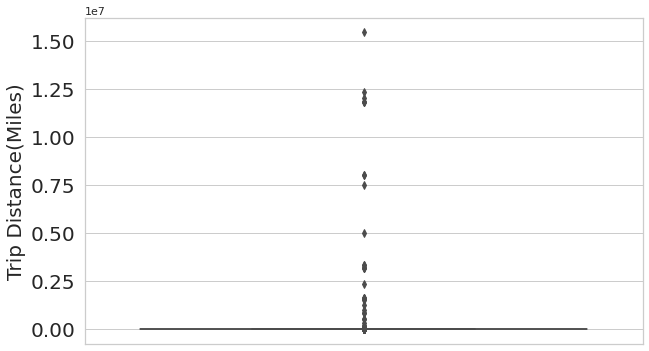

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("trip_distance", data = new_data_Jan_2015, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Trip Distance(Miles)", fontsize = 20)
plt.show()

In [ ]:
# We investigate Quartiles
quantile_tripDistance = new_data_Jan_2015.trip_distance.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print("{}th percentile value of trip distance is {}miles".format(int(i*100), quantile_tripDistance[i]))

0th percentile value of trip distance is 0.0miles
10th percentile value of trip distance is 0.63miles
20th percentile value of trip distance is 0.9miles
30th percentile value of trip distance is 1.1miles
40th percentile value of trip distance is 1.37miles
50th percentile value of trip distance is 1.68miles
60th percentile value of trip distance is 2.06miles
70th percentile value of trip distance is 2.6miles
80th percentile value of trip distance is 3.59miles
90th percentile value of trip distance is 5.99miles
100th percentile value of trip distance is 15420004.5miles


In [ ]:
quantile_tripDistance = new_data_Jan_2015.trip_distance.quantile(np.round(np.arange(0.991, 1.001, 0.001), 4))
qValues = np.round(np.arange(0.991, 1.001, 0.001), 3)
for i in qValues:
    print("{} percentile value of trip distance is {}miles".format((i*100), quantile_tripDistance[i]))

99.1 percentile value of trip distance is 18.43miles
99.2 percentile value of trip distance is 18.68miles
99.3 percentile value of trip distance is 18.92miles
99.4 percentile value of trip distance is 19.23miles
99.5 percentile value of trip distance is 19.6miles
99.6 percentile value of trip distance is 20.1miles
99.7 percentile value of trip distance is 20.68miles
99.8 percentile value of trip distance is 21.4miles
99.9 percentile value of trip distance is 23.1miles
100.0 percentile value of trip distance is 15420004.5miles


**Observation:** 99.9th percentile of trip distance is 22.58miles, however, 
100th percentile value is 15420004.9miles, which is very high. So, we are removing all the data points where trip distance is greater than 23miles.

In [ ]:
#Remouving courses with erounous speed
new_data_Jan_2015 = new_data_Jan_2015[(new_data_Jan_2015.trip_distance>0) & (new_data_Jan_2015.trip_distance<23)]

## Speed

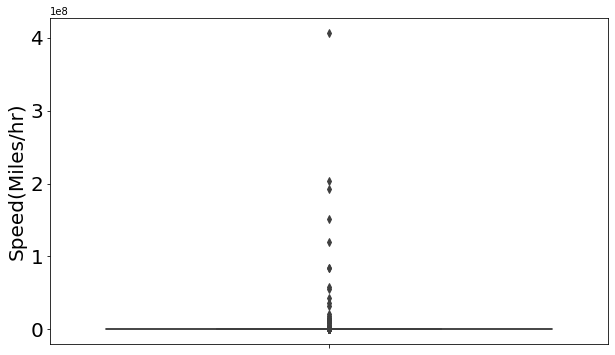

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("speed", data = new_data_Jan_2015, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Speed(Miles/hr)", fontsize = 20)
plt.show()

In [ ]:
quantile_speed = new_data_Jan_2015.speed.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))
qValues = np.round(np.arange(0.00, 1.01, 0.1), 4)
for i in qValues:
    print("{}th percentile value of speed is {}miles/hr".format(int(i*100), quantile_speed[i]))

0th percentile value of speed is -5760.0miles/hr
10th percentile value of speed is 6.334310850439882miles/hr
20th percentile value of speed is 7.764705882352942miles/hr
30th percentile value of speed is 8.897338403041825miles/hr
40th percentile value of speed is 9.956331877729257miles/hr
50th percentile value of speed is 11.050080775444265miles/hr
60th percentile value of speed is 12.272727272727273miles/hr
70th percentile value of speed is 13.790645879732738miles/hr
80th percentile value of speed is 15.970789593792789miles/hr
90th percentile value of speed is 20.23174971031286miles/hr
100th percentile value of speed is nanmiles/hr


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3942: RuntimeWarning:

invalid value encountered in multiply



In [ ]:
qValues = np.round(np.arange(0.991, 1.001, 0.001), 4)
quantile_speed = new_data_Jan_2015.speed.quantile(qValues)
for i in qValues:
    print("{} percentile value of speed is {}miles/hr".format((i*100), quantile_speed[i]))

99.1 percentile value of speed is 36.73940949935815miles/hr
99.2 percentile value of speed is 37.39744766890206miles/hr
99.3 percentile value of speed is 38.125435381681854miles/hr
99.4 percentile value of speed is 38.94230769230769miles/hr
99.5 percentile value of speed is 39.883446993180414miles/hr
99.6 percentile value of speed is 41.00769129665513miles/hr
99.7 percentile value of speed is 42.42343541944074miles/hr
99.8 percentile value of speed is 44.52488687782805miles/hr
99.9 percentile value of speed is 50.06783650988084miles/hr
100.0 percentile value of speed is nanmiles/hr


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3942: RuntimeWarning:

invalid value encountered in multiply



In [ ]:
#Deleting courses with erounous speed
new_data_Jan_2015 = new_data_Jan_2015[(new_data_Jan_2015.speed>0) & (new_data_Jan_2015.speed<45.31)]

## Total amount

<function matplotlib.pyplot.show>

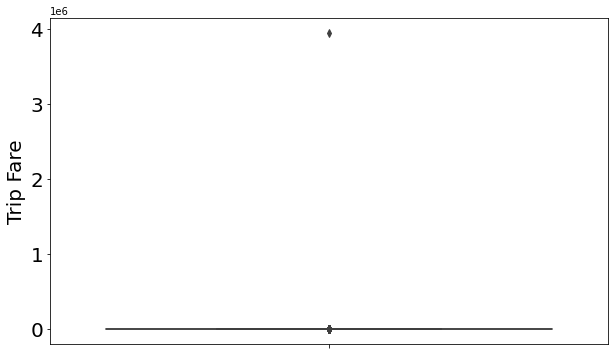

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("total_amount", data = new_data_Jan_2015, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Trip Fare", fontsize = 20)
plt.show

In [ ]:
quantile_totalAmount = new_data_Jan_2015.total_amount.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print("{}th percentile value of trip fare is {}".format(int(i*100), quantile_totalAmount[i]))

0th percentile value of trip fare is -450.3
10th percentile value of trip fare is 6.3
20th percentile value of trip fare is 7.56
30th percentile value of trip fare is 8.76
40th percentile value of trip fare is 9.8
50th percentile value of trip fare is 11.16
60th percentile value of trip fare is 12.8
70th percentile value of trip fare is 14.8
80th percentile value of trip fare is 18.3
90th percentile value of trip fare is 26.0
100th percentile value of trip fare is 3950611.6


In [ ]:
quantile_totalAmount = new_data_Jan_2015.total_amount.quantile(np.round(np.arange(0.991, 1.001, 0.001), 3))
qValues = np.round(np.arange(0.991, 1.001, 0.001), 3)
for i in qValues:
    print("{} percentile value of trip fare is {}".format((i*100), quantile_totalAmount[i]))

99.1 percentile value of trip fare is 69.6
99.2 percentile value of trip fare is 69.6
99.3 percentile value of trip fare is 69.73
99.4 percentile value of trip fare is 69.75
99.5 percentile value of trip fare is 70.0
99.6 percentile value of trip fare is 72.55060000000522
99.7 percentile value of trip fare is 75.33
99.8 percentile value of trip fare is 83.3502999999933
99.9 percentile value of trip fare is 100.0
100.0 percentile value of trip fare is 3950611.6



**Observation:**Here, 99.9th percentile fare amount of a trip is 86.6. However, 100th percentile of a fare amount is 3Million which is bizzare. Therefore, we have removedall the data points where fare amount is more than 99.9th percentile value

In [ ]:
#Deteting demands with eronous amount
new_data_Jan_2015 = new_data_Jan_2015[(new_data_Jan_2015.total_amount>0) & (new_data_Jan_2015.total_amount<86.6)]

##Pickup/Dropoff

In [ ]:
outside_NYC = new_data_Jan_2015[((new_data_Jan_2015.pickup_latitude <= 40.5774) | (new_data_Jan_2015.pickup_longitude <= -74.15) | (new_data_Jan_2015.pickup_latitude >= 40.9176) | (new_data_Jan_2015.pickup_longitude >= -73.7004))]

In [ ]:
locations = outside_NYC[['pickup_latitude', 'pickup_longitude']][:10000]
locationlist = locations.values.tolist()
map = folium.Map(location=[40.73,-73.93], zoom_start=12)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(map)
map

In [ ]:
#Deleting pickups / dropoff out of NYC
new_data_Jan_2015 = new_data_Jan_2015[(((new_data_Jan_2015.pickup_latitude >= 40.5774) & (new_data_Jan_2015.pickup_latitude <= 40.9176)) & ((new_data_Jan_2015.pickup_longitude >= -74.15) & (new_data_Jan_2015.pickup_longitude <= -73.7004)))]
new_data_Jan_2015 = new_data_Jan_2015[(((new_data_Jan_2015.dropoff_latitude >= 40.5774) & (new_data_Jan_2015.dropoff_latitude <= 40.9176)) & ((new_data_Jan_2015.dropoff_longitude >= -74.15) & (new_data_Jan_2015.dropoff_longitude <= -73.7004)))]

## Clustering Data

In [ ]:
#Clustering pickups
coord = new_data_Jan_2015[["pickup_latitude", "pickup_longitude"]].values
regions = MiniBatchKMeans(n_clusters = 30, batch_size = 10000).fit(coord)

In [ ]:
cluster_column = regions.predict(new_data_Jan_2015[["pickup_latitude", "pickup_longitude"]])
new_data_Jan_2015["pickup_cluster"] = cluster_column

In [ ]:
#Grouping the mounthly data by region
new_data_Jan_2015.rename(columns={'tpep_pickup_datetime':'time','trip_distance':'demand',},inplace=True)
new_data_Jan_2015['time'] = pd.to_datetime(new_data_Jan_2015['time'])
grouped_new_data_Jan_2015 = new_data_Jan_2015[["pickup_cluster", "time", "demand"]].groupby(by = ["pickup_cluster", "time"]).count()

## Preparing Weather Data

In [ ]:
meteo = meteo_Jan_2015.iloc[:-1,:]
meteo = meteo.set_index("Date time")

In [ ]:
#preparing weither data
weather_data = pd.DataFrame()
start = grouped_new_data_Jan_2015.loc[0].index[0].replace(minute=0, second=0)
end = grouped_new_data_Jan_2015.loc[0].index[-1].replace(minute=0, second=0)
weather_data["Date time"] = pd.date_range(start, end, freq='H' )
weather_data["Date time"] = pd.to_datetime(weather_data["Date time"] )
weather_data = weather_data.set_index("Date time")
weather_data['Temperature'] = meteo['Temperature']
weather_data['Wind Speed'] = meteo['Wind Speed']
weather_data = weather_data.fillna(method='backfill')

## Preparing clusters and saving each one in its csv file

In [ ]:
#Cluster example
cluster = grouped_new_data_Jan_2015.loc[0]
#Resampling Data in region j into one hour step
cluster = cluster.resample('1h').sum() 
#Feature Engineering
cluster['Date time'] = cluster.index
cluster['Date time'] = pd.to_datetime(cluster['Date time'].dt.strftime('%Y-%m-%d %H'))
cluster['hour']=cluster['Date time'].dt.hour 
cluster['day']=cluster['Date time'].dt.day
cluster['dayofweek']=cluster['Date time'].dt.dayofweek  
df_merge_col = pd.merge(cluster, weather_data, on='Date time')
cluster['temperature'] = df_merge_col.Temperature.values
cluster['wind_speed'] = df_merge_col['Wind Speed'].values

In [ ]:
cluster = cluster[['hour','day','dayofweek','temperature','wind_speed','demand']]
cluster.head()

hour  day  dayofweek  temperature  wind_speed  demand
time                                                                      
2015-01-01 00:00:00     0    1          3         27.6         6.3     638
2015-01-01 01:00:00     1    1          3         27.6         9.8     570
2015-01-01 02:00:00     2    1          3         27.4         9.7     448
2015-01-01 03:00:00     3    1          3         26.4         7.6     400
2015-01-01 04:00:00     4    1          3         26.6         7.4     280

In [ ]:
#Saving data per cluster per hour in each cluster file
for j in range(30):
    cluster = grouped_new_data_Jan_2015.loc[j]
    #Resampling Data in region j into one hour step
    cluster = cluster.resample('1h').sum() 
    #Feature Engineering
    cluster['Date time'] = cluster.index
    cluster['Date time'] = pd.to_datetime(cluster['Date time'].dt.strftime('%Y-%m-%d %H'))
    cluster['hour']=cluster['Date time'].dt.hour 
    cluster['day']=cluster['Date time'].dt.day
    cluster['dayofweek']=cluster['Date time'].dt.dayofweek  
    df_merge_col = pd.merge(cluster, weather_data, on='Date time')
    cluster['temperature'] = df_merge_col.Temperature.values
    cluster['wind_speed'] = df_merge_col['Wind Speed'].values
    del cluster['Date time']
    cluster = cluster[['hour','day','dayofweek','temperature','wind_speed','demand']]
    cluster.to_csv("/content/drive/My Drive/data-sets/nyc/NYC-data-2015/cluster_"+str(j).zfill(2)+".csv", mode='a', header=False)

# Visulizing clusters

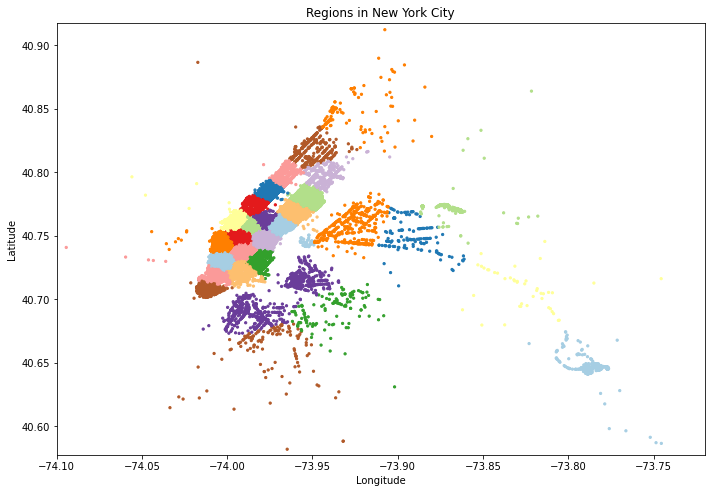

In [ ]:
#Plotting NYC Regions
NYC_latitude_range = (40.5774, 40.9176)
NYC_Longitude_range = (-74.15, -73.7004)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.scatter(x = new_data_Jan_2015.pickup_longitude.values[:70000], y = new_data_Jan_2015.pickup_latitude.values[:70000], c = new_data_Jan_2015.pickup_cluster.values[:70000], cmap = "Paired", s = 5)
ax.set_xlim(-74.10, -73.72)
ax.set_ylim(40.5774, 40.9176)
ax.set_title("Regions in New York City")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Cleaning Data For Rest months and saving clusters

In [ ]:
#Redoing the cleaning process for data from other months
for i in range(1,3,1):
  startTime = datetime.now()
  data_month = dd.read_csv("/content/drive/My Drive/data-sets/nyc/nyc-data/yellow_tripdata_2016-"+str(i).zfill(2)+".csv")
  meteo_month = pd.read_csv("/content/drive/My Drive/data-sets/nyc/nyc-weather/NYC-"+str(i).zfill(2)+"-2016.csv")

  meteo = meteo_month.iloc[:-1,:]
  meteo = meteo.set_index("Date time")

  print("Year 2016 - month = "+str(i))
  #Cleaning Data
  new_data_month = prepare_dataframe(data_month)
  #Deleting pickups / dropoff out of NYC
  new_data_month = new_data_month[(new_data_month.total_amount>0) & (new_data_month.total_amount<86.6)]
  new_data_month = new_data_month[(((new_data_month.pickup_latitude >= 40.5774) & (new_data_month.pickup_latitude <= 40.9176)) & ((new_data_month.pickup_longitude >= -74.15) & (new_data_month.pickup_longitude <= -73.7004)))]
  new_data_month = new_data_month[(((new_data_month.dropoff_latitude >= 40.5774) & (new_data_month.dropoff_latitude <= 40.9176)) & ((new_data_month.dropoff_longitude >= -74.15) & (new_data_month.dropoff_longitude <= -73.7004)))]
  
  #Deleting courses with trip duration > 12h
  new_data_month = new_data_month[(new_data_month.trip_duration>1) & (new_data_month.trip_duration<720)]
  #Deleting courses with erounous speed
  new_data_month = new_data_month[(new_data_month.speed>0) & (new_data_month.speed<45.31)]
  #Remouving courses with erounous speed
  new_data_month = new_data_month[(new_data_month.trip_distance>0) & (new_data_month.trip_distance<23)]
  #Remouving courses with erounous amount
  new_data_month = new_data_month[(new_data_month.total_amount>0) & (new_data_month.total_amount<86.6)]

  cluster_column = regions.predict(new_data_month[["pickup_latitude", "pickup_longitude"]])
  new_data_month["pickup_cluster"] = regions.predict(new_data_month[["pickup_latitude", "pickup_longitude"]])

  #Grouping the mounthly data by region
  new_data_month.rename(columns={'tpep_pickup_datetime':'time','trip_distance':'demand',},inplace=True)
  new_data_month['time'] = pd.to_datetime(new_data_month['time'])
  grouped_new_data_month = new_data_month[["pickup_cluster", "time", "demand"]].groupby(by = ["pickup_cluster", "time"]).count()

  #preparing weither data
  weather_data = pd.DataFrame()
  start = grouped_new_data_month.loc[0].index[0].replace(minute=0, second=0)
  end = grouped_new_data_month.loc[0].index[-1].replace(minute=0, second=0)
  weather_data["Date time"] = pd.date_range(start, end, freq='H' )
  weather_data["Date time"] = pd.to_datetime(weather_data["Date time"] )
  weather_data = weather_data.set_index("Date time")
  weather_data['Temperature'] = meteo['Temperature']
  weather_data['Wind Speed'] = meteo['Wind Speed']
  weather_data = weather_data.fillna(method='backfill')

  


  #Saving data per cluster per hour in each cluster file
  for j in range(30):
      cluster = grouped_new_data_month.loc[j]
      #Resampling Data in region j into one hour step
      cluster = cluster.resample('1h').sum() 
      #Feature Engineering
      cluster['Date time'] = cluster.index
      cluster['Date time'] = pd.to_datetime(cluster['Date time'].dt.strftime('%Y-%m-%d %H'))
      cluster['hour']=cluster['Date time'].dt.hour 
      cluster['day']=cluster['Date time'].dt.day
      cluster['dayofweek']=cluster['Date time'].dt.dayofweek  
      df_merge_col = pd.merge(cluster, weather_data, on='Date time')
      cluster['temperature'] = df_merge_col.Temperature.values
      cluster['wind_speed'] = df_merge_col['Wind Speed'].values
      del cluster['Date time']
      cluster = cluster[['hour','day','dayofweek','temperature','wind_speed','demand']]
      cluster.to_csv("/content/drive/My Drive/data-sets/nyc/NYC-data-2015/cluster_"+str(j).zfill(2)+".csv", mode='a', header=False)

  print("Time taken for creation of dataframe is {}".format(datetime.now() - startTime))
  

  print("-"*35)


Year 2016 - month = 1
Time taken for creation of dataframe is 0:07:43.487422
-----------------------------------
Year 2016 - month = 2
Time taken for creation of dataframe is 0:07:49.782029
-----------------------------------


# Reading Cleaned Data 

In this section we will take a random cluster to explore it's destibution, stationarity, trend and seasonal componants

In [ ]:
cluster_cleaned = pd.read_csv("/content/drive/My Drive/data-sets/nyc/NYC-data-2015-10min/cluster_"+str(0).zfill(2)+".csv")
cluster_cleaned['time'] = pd.to_datetime(cluster_cleaned['time'])
cluster_cleaned = cluster_cleaned.set_index('time' , drop=True)
cluster_cleaned

hour  day  dayofweek  temperature  wind_speed  demand
time                                                                      
2015-01-01 00:00:00     0    1          3         27.6         6.3     141
2015-01-01 00:10:00     0    1          3         27.6         6.3     266
2015-01-01 00:20:00     0    1          3         27.6         6.3     275
2015-01-01 00:30:00     0    1          3         27.6         6.3     339
2015-01-01 00:40:00     0    1          3         27.6         6.3     339
...                   ...  ...        ...          ...         ...     ...
2016-02-29 23:10:00    23   29          0         47.6        47.6      79
2016-02-29 23:20:00    23   29          0         47.6        47.6      74
2016-02-29 23:30:00    23   29          0         47.6        47.6      54
2016-02-29 23:40:00    23   29          0         47.6        47.6      46
2016-02-29 23:50:00    23   29          0         47.6        47.6      59

[61200 rows x 6 columns]

In [ ]:
split_date = pd.Timestamp('2016-01-01')
train = cluster_cleaned.loc[:split_date]
test =  cluster_cleaned.loc[split_date:]

# Exploring time serie / Seasonality / Trend

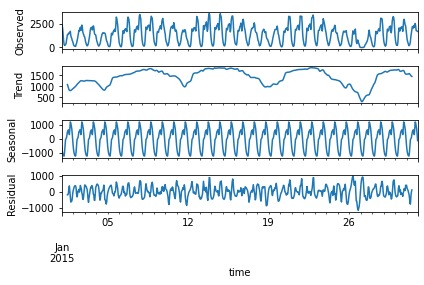

<Figure size 720x432 with 0 Axes>

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
result = seasonal_decompose(cluster.demand, model='additive')
result.plot()
pyplot.figure(figsize = (10,6))
pyplot.show()

Interpretation: We can see that the seasonality of the demand time serie is 24h

In [ ]:
from plotly.offline import init_notebook_mode, iplot
iplot([{
    'x': train.iloc[:,:].index,
    'y': train.iloc[:,:][col],
    'name': col
}  for col in pd.DataFrame(train['demand']).columns])

In [ ]:
from plotly.offline import init_notebook_mode, iplot
iplot([{
    'x': test.iloc[:,:].index,
    'y': test.iloc[:,:][col],
    'name': col
}  for col in pd.DataFrame(test['demand']).columns])

Visulizing the test set we can observe a strange behaviour of the data around Jan 24. this points wil affect our results of the model so we will take this in consideration.
A quick google research we can find that this behaviour is due the Bizzard that happend on the week of Jan 24 2016 in USA and NYC esspecially that closed the roads which means no taxi were taken. 
Source: https://www.nbcnewyork.com/news/local/nyc-new-york-city-blizzard-biggest-ever-january-23-2016/831660/

In [ ]:
#Stationarity test
import statsmodels.tsa.stattools as sts 
dftest = sts.adfuller(test.iloc[:,:].demand)
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -17.302189
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Interpretation (To do in article). Time serie is stationary

# Applying SARIMAX

## Defining SARIMAX Methods

In [ ]:
def get_sarima_params(data):
  p = d = q = range(0, 2)
  pdq = list(itertools.product(p, d, q))
  seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]
  result_table = pd.DataFrame(columns=['pda','seasonal_pda','aic'])

  for param in pdq:
      for param_seasonal in seasonal_pdq:
          try:
            mod = sm.tsa.statespace.SARIMAX(data,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            result_table = result_table.append({'pda':param, 'seasonal_pda':param_seasonal, 'aic':results.aic},ignore_index=True)
          except:
            continue

  optimal_params = result_table[result_table['aic']==result_table.aic.min()]
  order = optimal_params.pda.values[0]
  seasonal_order = optimal_params.seasonal_pda.values[0]
  return (order,seasonal_order)

In [ ]:
def apply_sarimax(train_data,train_exog, test_data, test_exog , order , seasonal_order):
  print('SARIMAX MODEL ORDERS ARE = {} {} '.format(order,seasonal_order))
   
  mod = sm.tsa.statespace.SARIMAX(train_data,exog=train_exog,order=order,seasonal_order=seasonal_order)
  results = mod.fit()
  
  pred = results.get_prediction(start=train_data.index[0],end=train_data.index[-1],exog=train_exog,dynamic=False)
  train_forecast = pred.predicted_mean.round()
  train_forecast[train_forecast<0] = 0


  pred1 = results.get_prediction(start=test_data.index[0],end=test_data.index[-1],exog=test_exog.iloc[:-1,:],dynamic=False)
  test_forecast = pred1.predicted_mean.round()
  test_forecast[test_forecast<0] = 0

  
  return (train_forecast,test_forecast)

def print_sarima_results(train_data,test_data,train_forecast,test_forecast):
  print('Train Mean Absolute Error:     ', mean_absolute_error(train_data , train_forecast))
  print('Train Root Mean Squared Error: ',np.sqrt(mean_squared_error(train_data , train_forecast)))
  print('Test Mean Absolute Error:      ', mean_absolute_error(test_data, test_forecast))
  print('Test Root Mean Squared Error:  ',np.sqrt(mean_squared_error(test_data, test_forecast)))

In [ ]:
#Data biassed to be deleted from test set (Due de 26 Jan 2016 bizzard )
start_bizzard = pd.Timestamp('2016-01-23')
end_bizzard = pd.Timestamp('2016-01-26')
indexes = test.loc[start_bizzard:end_bizzard].index

In [ ]:
#Applying Sarimax on demand data with exogenance variables on Cluster 0
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    #order,seasonal_order = get_sarima_params(train_data)
    #train_forecast, test_forecast = apply_sarima(train.demand,train.iloc[:,0:-1],test.demand,test.iloc[:,0:-1],order,seasonal_order)
    print('SARIMA MODEL ORDERS ARE {} {} = '.format(order,seasonal_order))
    train_data = pd.DataFrame(train['demand'])
    train_exog = train.loc[:,['hour','day'	,'dayofweek',	'temperature',	'wind_speed']]
    test_data = pd.DataFrame(test['demand'])
    test_exog = test.loc[:,['hour','day'	,'dayofweek',	'temperature',	'wind_speed']]
    order = (1, 0, 1) 
    seasonal_order = (1, 1, 1, 24)
    mod = sm.tsa.statespace.SARIMAX(train_data,exog=train_exog,order=order,seasonal_order=seasonal_order)
    results = mod.fit()
  
    pred = results.get_prediction(start=train_data.index[0],end=train_data.index[-1],exog=train_exog,dynamic=False)
    train_forecast = pred.predicted_mean.round()
    train_forecast[train_forecast<0] = 0


    pred1 = results.get_prediction(start=test_data.index[0],end=test_data.index[-1],exog=test_exog.iloc[:-1,:],dynamic=False)
    test_forecast = pred1.predicted_mean.round()
    test_forecast[test_forecast<0] = 0

    

    test_cleaned = test_data.drop(indexes)
    test_forecast_cleaned = test_forecast.drop(indexes)
    print_sarima_results(train_data,test_cleaned,train_forecast, test_forecast_cleaned)

SARIMA MODEL ORDERS ARE (1, 0, 1) (1, 1, 1, 24) = 
Train Mean Absolute Error:      56.55895445725374
Train Root Mean Squared Error:  79.7509227486451
Test Mean Absolute Error:       114.71324067300658
Test Root Mean Squared Error:   159.10602713678358


In [ ]:
#Applying Sarimax on demand data with exogenance variables on Cluster 2
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    train_data = pd.DataFrame(train['demand'])
    train_exog = train.loc[:,['hour','day'	,'dayofweek',	'temperature',	'wind_speed']]
    test_data = pd.DataFrame(test['demand'])
    test_exog = test.loc[:,['hour','day'	,'dayofweek',	'temperature',	'wind_speed']]
    
    
    order,seasonal_order = get_sarima_params(train_data)
    train_forecast, test_forecast = apply_sarima(train_data,train_exog,test_data,test_exog,order,seasonal_order)  


    #Ignoring test data between 23-26 Jan 2016
    test_cleaned = test_data.drop(indexes)
    test_forecast_cleaned = test_forecast.drop(indexes)
    
    print_sarima_results(train_data,test_cleaned,train_forecast, test_forecast_cleaned)

SARIMA MODEL ORDERS ARE (1, 0, 1) (1, 1, 1, 24) = 
Train Mean Absolute Error:      41.979111973519004
Train Root Mean Squared Error:  57.308667888333076
Test Mean Absolute Error:       56.31675201170446
Test Root Mean Squared Error:   78.00991721322202


## Visualizing Result

In [ ]:
result_df = pd.DataFrame(test)
result_df['predicted_value'] = test_forecast

In [ ]:
# Cluster 0
from plotly.offline import init_notebook_mode, iplot
iplot([{
    'x': result_df.index,
    'y': result_df[col],
    'name': col
}  for col in result_df.loc[:,['demand','predicted_value']].columns])

In [ ]:
# Cluster 2
from plotly.offline import init_notebook_mode, iplot
iplot([{
    'x': result_df.index,
    'y': result_df[col],
    'name': col
}  for col in result_df.loc[:,['demand','predicted_value']].columns])

Note that the period of 23 Jan 2016 to 26 Jan 2016 is an anormal period where the seasonal model SARIMAX can't be able to detect this outliers. this period was not taken in considiration when evaluating the model.

# Bonus:  On all clusters

In [ ]:
def save_prediction(df,cluster_number):
  df.to_csv('/content/drive/My Drive/data-sets/nyc/predictions/cluster_{}_predictions.csv'.format(str(cluster_number).zfill(2)))

In [ ]:
def save_performance(train_data,test_data,train_forecast,test_forecast):
  #Save results on file
    performence = []
    performence.append(files_dict[i])
    performence.append(mean_absolute_error(train_data , train_forecast))
    performence.append(np.sqrt(mean_squared_error(train_data , train_forecast)))
    performence.append(mean_absolute_error(test_data, test_forecast))
    performence.append(np.sqrt(mean_squared_error(test_data, test_forecast)))
    performence.append(str(datetime.now() - startTime))

    from csv import writer 
    with open('/content/drive/My Drive/data-sets/nyc/performance.csv', 'a', newline='') as file:
        writer = writer(file)
        writer.writerow(performence)

In [ ]:
models = []
results_dfs = []

In [ ]:
# Apply SARIMAX on All clusters and save results
TotalTime = datetime.now()
split_date = pd.Timestamp('2016-01-01')
for i in range(0,2,1):
  startTime = datetime.now()

  cluster_cleaned = pd.read_csv("/content/drive/My Drive/data-sets/NYC-data-2015/cluster_"+str(i).zfill(2)+".csv",header=None,names= ['time','hour','day','dayofweek','temperature','wind_speed','demand'])
  cluster_cleaned['time'] = pd.to_datetime(cluster_cleaned['time'])
  cluster_cleaned = cluster_cleaned.set_index('time' , drop=True)
  print('Prediction for cluster  {}'.format(i))
  
  #cluster_diff = difference(cluster_cleaned)
  train = cluster_cleaned.loc[:split_date]
  test =  cluster_cleaned.loc[split_date:]

  train_data = pd.DataFrame(train['demand'])
  train_exog = train.loc[:,['hour','day'	,'dayofweek',	'temperature',	'wind_speed']]
  test_data = pd.DataFrame(test['demand'])
  test_exog = test.loc[:,['hour','day'	,'dayofweek',	'temperature',	'wind_speed']]

  order,seasonal_order = get_sarima_params(train_data)
  train_forecast, test_forecast = apply_sarima(train_data,train_exog,test_data,test_exog,order,seasonal_order)  

  test_cleaned = test_data.drop(indexes)
  test_forecast_cleaned = test_forecast.drop(indexes)

  print_sarima_results(train_data,test_cleaned,train_forecast, test_forecast_cleaned)


  

  results_df = pd.DataFrame(test.demand)
  results_df['predicted_value'] = test_forecast

  results_dfs.append(results_df)

  #Save predictions results
  save_predictions(results_df,i)
  save_performance(train_data,test_cleaned,train_forecast, test_forecast_cleaned)

  #Optional: Save models for deploiement
  #models.append(results)


  print("Total Time taken for cluster =  = "+str(datetime.now() - startTime))
  print("-"*35)
  
  print("Total Time taken by all comunes = "+str(datetime.now() - TotalTime))

**This was all, hope you found this helpfull, waiting for your feedback on medium [here](https://medium.com/@abdelkader_bouregag)**